In [18]:
import numpy as np

test_motifs = np.genfromtxt('data__for_nerds/new_test_motifs.csv',dtype='U')
test_motifxFamMatrix = np.genfromtxt('data__for_nerds/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data__for_nerds/fams.csv',dtype='U')

In [25]:
musite_fams = np.array(['CDK','CK2','MAPK','PKA','PKC'])
fam_idc = [ np.where(fams==fam)[0][0] for fam in musite_fams ]

test_motifxFamMatrix = test_motifxFamMatrix[:,fam_idc]
fams = musite_fams

y_test = test_motifxFamMatrix

In [24]:
test_motifxFamMatrix.shape

(1179, 5)

In [20]:
from Bio import SeqIO

f = 'test_musite.fasta'
fasta_content = SeqIO.parse(open(f),'fasta')

test_seqs = []
for fasta in fasta_content:
    name, sequence = fasta.id, str(fasta.seq)
    test_seqs.append(sequence)

In [34]:
y_score.shape

(1179, 5)

In [47]:
import os

y_score = np.zeros((y_test.shape[0],y_test.shape[1]),dtype=float)

for fam_file in os.listdir("musite_results/"):
    
    fam = fam_file [ fam_file.find('_')+1 : fam_file.rfind('.') ]
    f_idx = np.where(fams==fam)[0][0]
    
    ofile = open(os.path.join("musite_results/", fam_file))
    lines = ofile.readlines()
    
    for line in lines:
        line = [x.strip() for x in line.split('\t')]
        if line[1]=='26': # 25th amino acid ... the phosphosite
            m_idx = line[0].replace("\"","")
            m_idx = m_idx.replace(">","")
            m_idx = int(m_idx)
            y_score[m_idx][f_idx] = float(line[3])           

In [49]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

average_precision["micro"] = average_precision_score(y_test, y_score,average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score, average="macro")

In [50]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
import numpy as np

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(fams)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(fams))]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(len(fams)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(fams)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


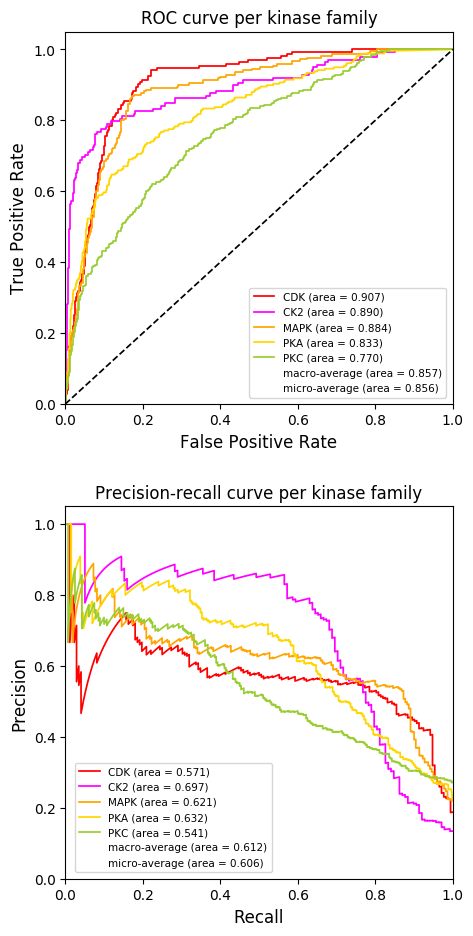

In [55]:
from itertools import cycle
import matplotlib.pyplot as plt

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
lw = 1.25

############################################################
###################  AUROC #################################
############################################################

colors = cycle(['red','magenta','orange', 'gold','yellowgreen','turquoise', 'blue', 'purple']) 
lines = []
labels = []

l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(roc_auc["micro"]))
l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(roc_auc["macro"]))

for i, color in zip( range( len(fams) ), colors):
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'    
    l, = ax1.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    labels.append('{0} (area = {1:0.3f})'.format(fclass, roc_auc[i]))
    lines.append(l)

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12) 
ax1.set_title('ROC curve per kinase family',fontsize=12) 
labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax1.legend(lines, labels, loc=(0.475, .0175), fontsize=7.5)  # (1.05, .0)

############################################################
###############  PRECISION-RECALL ##########################
############################################################

colors = cycle(['red','magenta','orange', 'gold','yellowgreen','turquoise', 'blue', 'purple']) 
lines = []
labels = []

l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('micro-average (area = {0:0.3f})'.format(average_precision["micro"]))
l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('macro-average (area = {0:0.3f})'.format(average_precision["macro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = ax2.plot(recall[i], precision[i], color=color, lw=lw)
    lines.append(l)
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'
    labels.append('{0} (area = {1:0.3f})'.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) 
ax2.set_ylabel('Precision',fontsize=12) 
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) 

labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax2.legend(lines, labels, loc=(0.025, .0175), fontsize=7.5) # (1.05, .0)

plt.savefig("FIGS_comparisons/musiteDeep_roc_prc", bbox_inches='tight')
plt.show()

In [ ]:
CDK, CK2, MAPK, PKC, Src